In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import numpy as np
from tqdm.notebook import tqdm

from scipy.stats import gaussian_kde
import ot

In [15]:
kk=0

In [16]:
device = 'cuda:0'

In [17]:
# Define a Convolutional Autoencoder model
class ConvAutoencoder(nn.Module):
    def __init__(self, embedding_dim=8):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=0, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
              nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=0, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=0),
            nn.Sigmoid(),
        )
        self.embedding_encoder = nn.Sequential(
            nn.Linear(128 * 2 * 2, 512),
            nn.ReLU(),
            nn.Linear(512, embedding_dim)
            )
        self.embedding_decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * 2 * 2)
            )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten        
        embedding = self.embedding_encoder(x)
        #embedding = embedding/torch.norm(embedding,p=2,dim=-1,keepdim=True)
        xhat = self.decoder(self.embedding_decoder(embedding).view(x.size(0), 128, 2, 2))
        return xhat, embedding

In [18]:
# Define training parameters
batch_size = 512
learning_rate = 1e-4
num_epochs = 50

In [19]:
transform = transforms.Compose([transforms.ToTensor()])

# Load the EMNIST dataset with the 'byclass' split
train_dataset = datasets.EMNIST(root='./data', split='byclass', train=True, transform=transform, download=True)
test_dataset = datasets.EMNIST(root='./data', split='byclass', train=False, transform=transform, download=True)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [20]:
def visualize_data(data_loader, rows=3, cols=5):
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i, (images, labels) in enumerate(data_loader):
        for j in range(rows * cols):
            ax[j // cols, j % cols].imshow(images[j].squeeze(), cmap='gray')
            ax[j // cols, j % cols].set_title(f'Label: {labels[j].item()}')
            ax[j // cols, j % cols].axis('off')
        break  # We only need the first batch
    plt.tight_layout()
    plt.show()


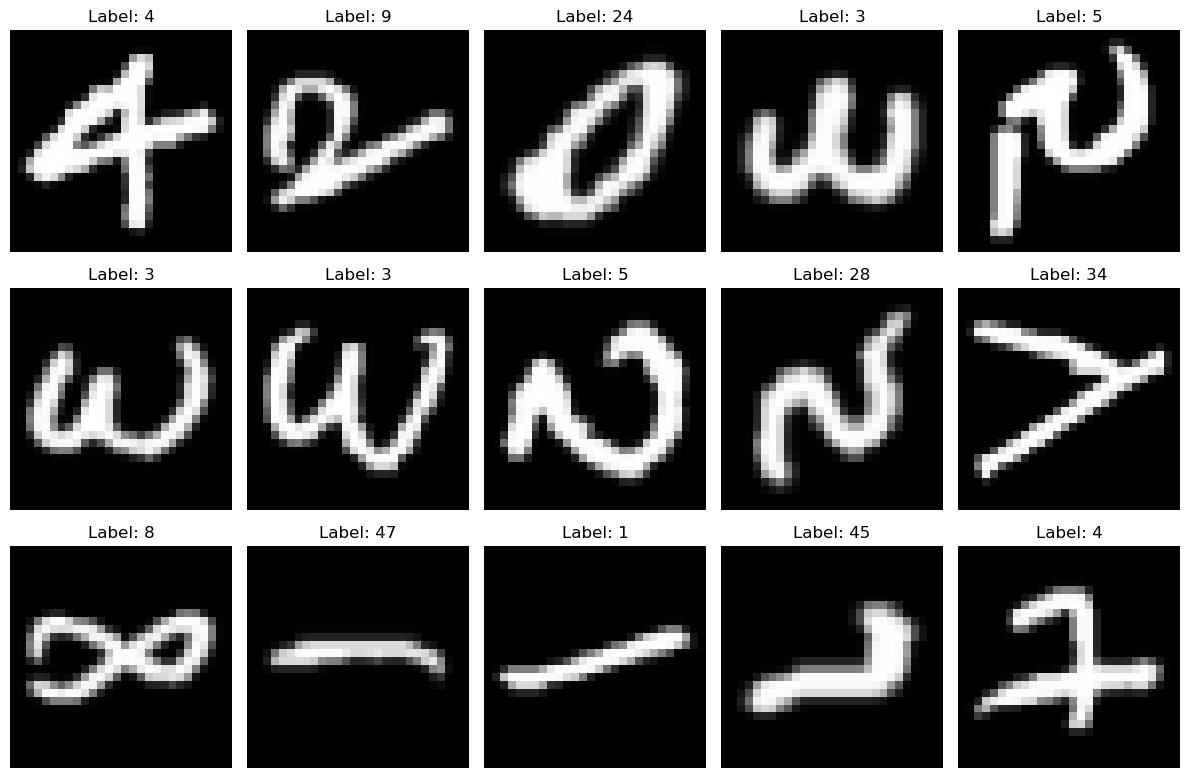

In [21]:
visualize_data(train_loader)

In [17]:
# Initialize the model and optimizer
model = ConvAutoencoder(embedding_dim=6)
model = model.to(device)
criterion1 = nn.BCELoss()
criterion2 = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
# Training loop
train_time_AE = []
train_bce_loss = []
train_mse_loss = []
for epoch in tqdm(range(num_epochs)):
    tic = time.time()
    bce_loss_epoch=0.0
    mse_loss_epoch=0.0
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()        
        outputs, _ = model(images)
        loss1 = criterion1(outputs, images)
        loss2 = criterion2(outputs, images)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        bce_loss_epoch+=loss1.item()
        mse_loss_epoch+=loss2.item()
    toc = time.time()
    train_time_AE.append(toc-tic)
    train_bce_loss.append(bce_loss_epoch/len(train_loader))
    train_mse_loss.append(mse_loss_epoch/len(train_loader))
    print(f'Epoch [{epoch + 1}/{num_epochs}], BCE Loss/epoch: {train_bce_loss[-1]:.4f}, MSE Loss/epoch: {train_mse_loss[-1]:.4f}, Time/epoch: {toc-tic:.4f}')
torch.save(model.state_dict(), './AE_EMNIST_{}.pt'.format(kk))
model.load_state_dict(torch.load('./AE_EMNIST_{}.pt'.format(kk)))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], BCE Loss/epoch: 0.3327, MSE Loss/epoch: 0.0781, Time/epoch: 72.1652
Epoch [2/50], BCE Loss/epoch: 0.2396, MSE Loss/epoch: 0.0431, Time/epoch: 72.0495
Epoch [3/50], BCE Loss/epoch: 0.2134, MSE Loss/epoch: 0.0332, Time/epoch: 71.9367
Epoch [4/50], BCE Loss/epoch: 0.2005, MSE Loss/epoch: 0.0295, Time/epoch: 71.9108
Epoch [5/50], BCE Loss/epoch: 0.1943, MSE Loss/epoch: 0.0280, Time/epoch: 71.9324
Epoch [6/50], BCE Loss/epoch: 0.1907, MSE Loss/epoch: 0.0270, Time/epoch: 72.0472
Epoch [7/50], BCE Loss/epoch: 0.1881, MSE Loss/epoch: 0.0263, Time/epoch: 71.9760
Epoch [8/50], BCE Loss/epoch: 0.1862, MSE Loss/epoch: 0.0257, Time/epoch: 72.0565
Epoch [9/50], BCE Loss/epoch: 0.1845, MSE Loss/epoch: 0.0251, Time/epoch: 71.9824
Epoch [10/50], BCE Loss/epoch: 0.1831, MSE Loss/epoch: 0.0247, Time/epoch: 72.0984
Epoch [11/50], BCE Loss/epoch: 0.1818, MSE Loss/epoch: 0.0242, Time/epoch: 72.1792
Epoch [12/50], BCE Loss/epoch: 0.1807, MSE Loss/epoch: 0.0239, Time/epoch: 71.9878
Epoch [13/50]

<All keys matched successfully>

/home/shahbaa/miniconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


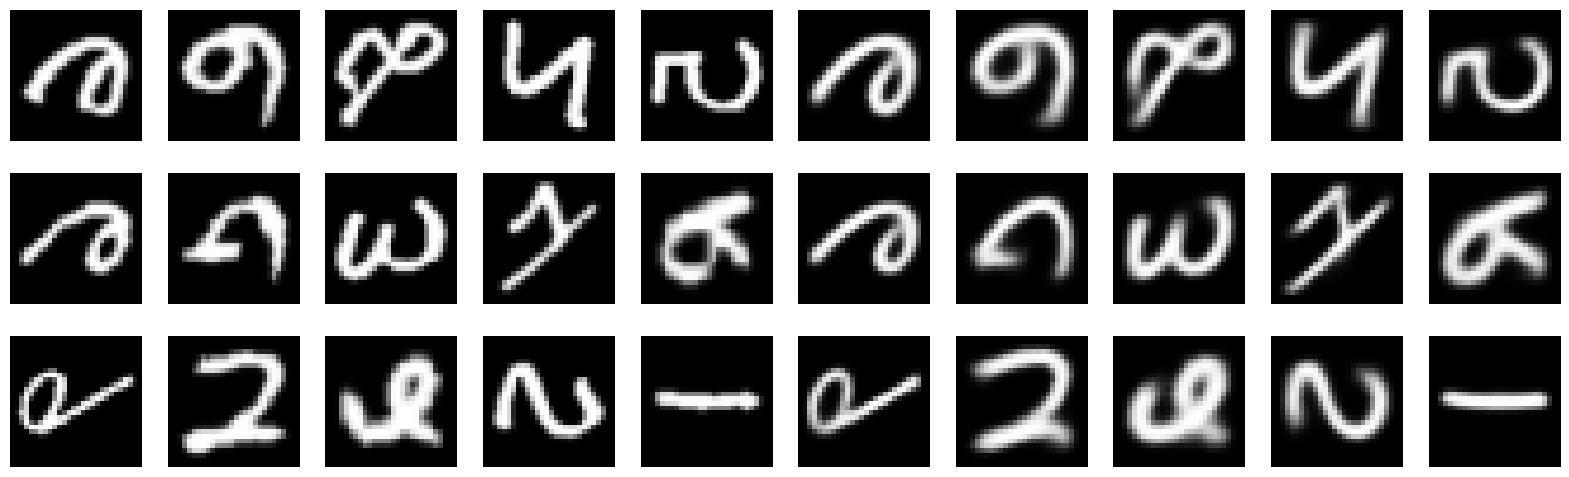

tensor(0.1635) tensor(0.0585)


In [19]:
embeddings = []
labels = []
BCE = []
MSE = []
for data in test_loader:
    images, y = data    
    images = images.to(device)
    outputs, embedding = model(images)
    BCE.append(nn.BCELoss(reduce=False)(outputs,images).mean(dim=[1,2,3]).detach().cpu())
    MSE.append(nn.MSELoss(reduce=False)(outputs,images).mean(dim=[1,2,3]).detach().cpu())
    embeddings.append(embedding.detach().cpu())
    labels.append(y)

embeddings = torch.cat(embeddings)
labels = torch.cat(labels).numpy()
# k = gaussian_kde(embeddings.numpy().T)
# fig, ax = plt.subplots(1, 2, figsize=(20,10), subplot_kw={'projection': "mollweide"})
# scatter_mollweide_ax(embeddings,ax[0],c=labels)
# plot_utils.projection_mollweide(lambda x: k.pdf(x.T), ax[1])
# plt.show()

fig, ax = plt.subplots(3, 10, figsize=(20, 6))
for i in range(3):
    for j in range(10):
        if j < 5:  # First half for images
            ax[i, j].imshow(images[i*5+j, ...].squeeze().detach().cpu(), cmap='gray')
        else:  # Second half for outputs
            ax[i, j].imshow(outputs[i*5+j-5, ...].squeeze().detach().cpu(), cmap='gray')
        ax[i, j].axis('off')
plt.show()
BCE = torch.cat(BCE)
MSE = torch.cat(MSE)
print(BCE.mean(),BCE.std())

In [20]:
test_bce_loss_array = np.array(BCE.numpy())
np.save('./test_bce_loss_initial25_{}.npy'.format(kk), test_bce_loss_array)
test_mse_loss_array = np.array(MSE.numpy())
np.save('./test_mse_loss_initial25_{}.npy'.format(kk), test_mse_loss_array)
test_embeddings = np.array(embeddings.numpy())
np.save('./test_embeddings_initial25_{}.npy'.format(kk), test_embeddings)
test_labels = np.array(labels)
np.save('./test_labels_initial25_{}.npy'.format(kk), test_labels)

In [32]:
# embedding_dict={'initial':embedding_initial25,'ri1_s3wd':embedding_ri1_s3wd,'s3wd':embedding_S3WD,'sswd':embedding_SSWD}
# w_prior=[]
# for embd in embedding_dict.keys():
#     W=getOT(embedding_dict[embd],prior)
#     print(embd,'=',W)
#     w_prior.append(W)
    